# Classification

In [1]:
import pandas as pd
import numpy as np

# Metrics and model evaluation
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, learning_curve, validation_curve
from sklearn.pipeline import Pipeline

# Classifiers
import wittgenstein as lw
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

## Decision tree visualization
from IPython.display import Image 
import pydotplus

from sklearn.decomposition import PCA

# Visualization
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import plotly.figure_factory as ff
from IPython.display import display
pd.options.plotting.backend = "plotly"
pio.templates.default = "seaborn"

pd.set_option('display.max_columns', None)

## Utility functions

In [2]:
models = []

def get_grid_search(estimator, parameters, normalization=True):
  estimator.random_state = 42
  if normalization:
      pipeline = Pipeline(steps=[('scaler', MinMaxScaler()), ('clf', estimator)])
  else:
      pipeline = Pipeline(steps=[('clf', estimator)])

  return GridSearchCV(pipeline, param_grid=parameters, cv=5, n_jobs=-1, refit=True, return_train_score=True)

def print_grid_search_results(clf):
  df = pd.DataFrame(clf.cv_results_)[['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score')
  display(df.head(10).style.set_caption('Top 10 Grid Search results').hide_index())

def report_scores(y_test, y_pred):
  print(classification_report(y_test, y_pred, target_names=classes, zero_division=0, sample_weight=None))

def plot_confusion_matrix(cm, classes, normalize=False):
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  # px.imshow(cm, x=classes, y=classes, title='Confusion matrix', color_continuous_scale="Blues", labels=dict(x="Real value", y="Predicted value", color="Records"), text_auto=True)
  fig = ff.create_annotated_heatmap(cm[[1, 0]], x=classes, y=classes, colorscale='Blues', showscale=True)
  fig.update_layout(xaxis = dict(title='Predicted value'), yaxis = dict(title='Real value'))
  fig.show()

def plot_learning_curve(clf, X, y, scoring='accuracy', cv=5, train_sizes=np.linspace(.1, 1.0, 5), 
                        shuffle=False, random_state=None):

    train_sizes, train_scores, test_scores = learning_curve(clf, X, y, train_sizes=train_sizes, cv=cv,
                                                            scoring=scoring, n_jobs=-1, shuffle=shuffle,
                                                            random_state=random_state)
    mean_train_score = np.mean(train_scores, axis=1)
    std_train_score = np.std(train_scores, axis=1)
    mean_test_score = np.mean(test_scores, axis=1)
    std_test_score = np.std(test_scores, axis=1)

    fig = go.Figure()

    fig.add_trace(go.Scatter(x=train_sizes, y=mean_train_score, name='train score', line=dict(color='royalblue')))
    fig.add_trace(go.Scatter(x=train_sizes, y=mean_train_score + std_train_score, mode="lines", showlegend=False, line=dict(width=0)))
    fig.add_trace(go.Scatter(x=train_sizes, y=mean_train_score - std_train_score, fill='tonexty', showlegend=False, 
      fillcolor='rgba(65,105,225,0.2)',
      line_color='rgba(255,255,255,0)',))

    fig.add_trace(go.Scatter(x=train_sizes, y=mean_test_score, name='cross-validation score', line=dict(color='firebrick')))
    fig.add_trace(go.Scatter(x=train_sizes, y=mean_test_score + std_test_score, mode="lines", showlegend=False, line=dict(width=0)))
    fig.add_trace(go.Scatter(x=train_sizes, y=mean_test_score - std_test_score, fill='tonexty', showlegend=False, 
      fillcolor='rgba(255,107,107,0.2)',
      line_color='rgba(255,255,255,0)',))

    model_name = str(clf.__class__.__name__)
    fig.update_layout(title=f'Learning Curve for {model_name}',
                   xaxis_title='Train set size',
                   yaxis_title='Accuracy')
    fig.show()

def plot_validation_curve(clf, X, y, parameters, validation_parameter, scoring='accuracy', cv=5):
  param_range = parameters[validation_parameter]
  train_scores, test_scores = validation_curve(clf, X, y, param_name=validation_parameter, param_range=param_range,
                                                 cv=cv, scoring=scoring, n_jobs=-1)
  mean_train_score = np.mean(train_scores, axis=1)
  std_train_score = np.std(train_scores, axis=1)
  mean_test_score = np.mean(test_scores, axis=1)
  std_test_score = np.std(test_scores, axis=1)

  fig = go.Figure()

  fig.add_trace(go.Scatter(x=param_range, y=mean_train_score, name='train score', line=dict(color='royalblue')))
  fig.add_trace(go.Scatter(x=param_range, y=mean_train_score + std_train_score, mode="lines", showlegend=False, line=dict(width=0)))
  fig.add_trace(go.Scatter(x=param_range, y=mean_train_score - std_train_score, fill='tonexty', showlegend=False, 
    fillcolor='rgba(65,105,225,0.2)',
    line_color='rgba(255,255,255,0)',))

  fig.add_trace(go.Scatter(x=param_range, y=mean_test_score, name='cross-validation score', line=dict(color='firebrick')))
  fig.add_trace(go.Scatter(x=param_range, y=mean_test_score + std_test_score, mode="lines", showlegend=False, line=dict(width=0)))
  fig.add_trace(go.Scatter(x=param_range, y=mean_test_score - std_test_score, fill='tonexty', showlegend=False, 
    fillcolor='rgba(255,107,107,0.2)',
    line_color='rgba(255,255,255,0)',))

  model_name = str(clf.__class__.__name__)
  fig.update_layout(title=f'Validation Curve for {model_name}',
                  xaxis_title=validation_parameter,
                  yaxis_title='Accuracy')
  fig.show()


def report(clf, X, Y, y_test, y_pred, model_classes, parameters=None, validation_parameter=None):
  print_grid_search_results(clf)
  cm = confusion_matrix(y_test, y_pred, labels=model_classes)
  plot_confusion_matrix(cm, classes=classes)
  report_scores(y_test, y_pred)
  if parameters and validation_parameter:
    plot_validation_curve(clf.best_estimator_, X, Y, parameters, validation_parameter)
  plot_learning_curve(clf.best_estimator_, X, Y)

def fit_and_report(name, estimator, parameters, X, Y, x_train, y_train, x_test, y_test, validation_parameter, normalization=True):
  # add clf to parameters
  parameters = {'clf__' + k: v for k, v in parameters.items()}
  validation_parameter = 'clf__' + validation_parameter

  clf = get_grid_search(estimator, parameters, normalization).fit(x_train, y_train)
  y_pred = clf.predict(x_test)
  models.append((name, clf.best_estimator_))
  report(clf, X, Y, y_test, y_pred, clf.classes_, parameters, validation_parameter)
  return clf.best_estimator_

## Pre-processing

In [3]:
df_players_complete = pd.read_csv("./datasets/players.csv", index_col=0)

### Label computation

#### Median splitting

In [4]:
df_players_complete['is_high_ranked'] = np.digitize(df_players_complete['mean_rank_points'], bins=[df_players_complete['mean_rank_points'].median()])
print(df_players_complete['is_high_ranked'].value_counts())
px.histogram(df_players_complete, x="mean_rank_points", color="is_high_ranked", title="Histogram of mean rank points")

1    1499
0    1498
Name: is_high_ranked, dtype: int64


#### Pareto splitting

In [5]:
# # lowest 80% of mean rank points are considered low ranked
# df_players_complete['is_high_ranked'] = np.digitize(df_players_complete['mean_rank_points'], bins=[df_players_complete['mean_rank_points'].quantile(0.8)])
# print(df_players_complete['is_high_ranked'].value_counts())
# px.histogram(df_players_complete, x="mean_rank_points", color="is_high_ranked", title="Histogram of mean rank points")

#### K-means

In [6]:
# # Apply k-means to identify cluster of good and bad players
# from sklearn.cluster import KMeans

# feautures = ['max_tourney_revenue', 'mean_rank_points', 'lrpOnMxrp', 'matches_won_ratio']
# df_data = df_players_complete[feautures].reset_index(drop=True)
# #df_data = pd.DataFrame(MinMaxScaler().fit_transform(df_data), columns=df_data.columns)
# #df_data = df_data.round(3)
# kmeans = KMeans(n_clusters=2, n_init=10, max_iter=100, init="k-means++", random_state=42).fit(df_data)
# df_players_complete['cluster'] = kmeans.labels_

# # is high ranked based on cluster results
# df_players_complete['is_high_ranked'] = df_players_complete['cluster']
# # print number of players
# print(df_players_complete['is_high_ranked'].value_counts())
# px.histogram(df_players_complete, x="mean_rank_points", color="is_high_ranked", title="Histogram of mean rank points")

#### Choice of the label to use

In [7]:
classes = ['low_ranked', 'high_ranked']
df_players = df_players_complete.copy()
df_players['is_high_ranked'] = np.digitize(df_players['mean_rank_points'], bins=[df_players['mean_rank_points'].median()])
df_players[['mean_rank_points', 'is_high_ranked']]
df_players.drop(columns=['mean_rank_points'], inplace=True)
df_players

,name,gender,total_tourneys_played,total_matches_played,total_matches_won,matches_won_ratio,mean_performance_index,max_performance_index,min_performance_index,performance_index_entropy,ht,age,hand,mean_minutes,max_minutes,minutes_entropy,max_rank_points,last_rank_points,variance_rank_points,lrpOnAvgrp,lrpOnMxrp,mean_tourney_spectators,max_tourney_spectators,mean_tourney_revenue,max_tourney_revenue,rel_ace,rel_df,rel_1stIn,rel_1stWon,rel_2ndWon,1WonOn1In,1WonOnTotWon,rel_ptsWon,rel_bpFaced,rel_bpSaved,rel_gmsWon,is_high_ranked
14,abbie myers,f,81,157,75.0,0.477707,0.290166,1.000000,0.0,4.595780,NaN,21.541410,r,98.000000,143.0,1.912948,209.0,175.0,4132.180616,1.770753,0.837321,3378.840764,15583.0,667262.958917,2876086.35,0.031739,0.070857,0.578607,0.341164,0.179801,0.590180,0.654515,0.461660,0.064469,0.396978,0.506549,1
22,abhinav sanjeev shanmugam,m,8,16,8.0,0.500000,0.303571,0.666667,0.0,2.325714,NaN,17.941136,u,88.666667,156.0,2.667782,21.0,7.0,33.433594,1.154639,0.333333,3806.562500,6943.0,764813.976875,1460820.61,0.092799,0.053235,0.470209,0.341783,0.260739,0.728696,0.569641,0.508137,0.054850,0.585260,0.479098,0
29,abigail tere apisah,f,61,126,74.0,0.587302,0.355820,0.833333,0.0,4.545294,NaN,23.745380,u,87.571429,125.0,2.583600,181.0,96.0,1623.900731,0.927607,0.530387,2857.515873,4448.0,546377.090873,1012331.80,0.018490,0.070367,0.581215,0.368487,0.191751,0.635412,0.663208,0.544618,0.064519,0.576609,0.566284,1
36,adam el mihdawy,m,17,23,6.0,0.260870,0.086957,0.166667,0.0,2.484907,NaN,26.576318,u,58.869565,85.0,3.064532,160.0,31.0,1216.944215,0.266510,0.193750,3072.043478,4284.0,589305.863913,888975.70,0.064123,0.119067,0.450848,0.326516,0.221596,0.719894,0.592229,0.472459,0.062262,0.486949,0.415704,1
43,adam pavlasek,m,95,201,109.0,0.542289,0.315535,0.833333,0.0,4.919851,NaN,21.240246,r,94.390374,191.0,5.180816,684.0,88.0,24954.298408,0.227788,0.128655,5168.691542,15979.0,997375.639453,3761778.69,0.064546,0.033647,0.608423,0.418225,0.196069,0.686969,0.679038,0.505872,0.047200,0.578063,0.514447,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10083,zoe kruger,f,42,76,34.0,0.447368,0.214912,0.666667,0.0,3.905690,NaN,14.253251,u,72.571429,90.0,1.928975,41.0,36.0,110.298227,1.290459,0.878049,3294.368421,9552.0,639165.078421,2484975.25,0.011074,0.074130,0.505826,0.284635,0.143643,0.564757,0.667521,0.426711,0.081302,0.378571,0.472897,0
10086,zoi meers,f,24,26,1.0,0.038462,0.019231,0.166667,0.0,1.098612,NaN,15.868583,u,NaN,NaN,0.000000,3.0,3.0,0.000000,1.000000,1.000000,3457.192308,4629.0,697359.572692,1073007.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.219200,0
10091,zoziya kardava,f,45,78,32.0,0.410256,0.228253,0.833333,0.0,3.778199,NaN,15.123888,u,NaN,NaN,0.000000,17.0,17.0,5.894719,1.761996,1.000000,3184.884615,6203.0,645838.422821,1436125.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.465158,0
10092,zsombor piros,m,40,86,47.0,0.546512,0.310770,0.666667,0.0,4.136414,NaN,17.319644,r,102.058824,260.0,4.376902,108.0,106.0,618.492834,1.429064,0.981481,4336.686047,8375.0,814053.739419,1804103.26,0.044268,0.035073,0.592749,0.386881,0.207977,0.653105,0.648855,0.503334,0.052124,0.530733,0.506056,1


In [8]:
df_players.is_high_ranked.value_counts().plot(kind='bar')

### Feature choice

In [9]:
features_correlated_with_high_ranked = ['max_rank_points', 'last_rank_points', 'variance_rank_points', 'max_tourney_spectators', 'max_tourney_revenue', 'lrpOnMxrp', 'lrpOnAvgrp']
# drop correlated features
df_players = df_players.drop(columns=features_correlated_with_high_ranked)

# drop all columns with missing values
df_players = df_players.dropna(axis=1)

# consider only numeric features
df_players = df_players.select_dtypes(include=['int64', 'float64'])

In [10]:
df_players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2997 entries, 14 to 10099
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   total_tourneys_played      2997 non-null   int64  
 1   total_matches_played       2997 non-null   int64  
 2   total_matches_won          2997 non-null   float64
 3   matches_won_ratio          2997 non-null   float64
 4   mean_performance_index     2997 non-null   float64
 5   max_performance_index      2997 non-null   float64
 6   min_performance_index      2997 non-null   float64
 7   performance_index_entropy  2997 non-null   float64
 8   age                        2997 non-null   float64
 9   minutes_entropy            2997 non-null   float64
 10  mean_tourney_spectators    2997 non-null   float64
 11  mean_tourney_revenue       2997 non-null   float64
 12  rel_gmsWon                 2997 non-null   float64
 13  is_high_ranked             2997 non-null   int

### Splitting into train and test

In [11]:
#df_players_norm = pd.DataFrame(MinMaxScaler().fit_transform(df_players), columns=df_players.columns)

X = df_players.drop(columns=['is_high_ranked'])
Y = df_players['is_high_ranked']
x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.3, random_state=0)

## Classification

### Decision Tree

In [12]:
parameters = {'max_depth': [2,3,4,5,6,7,8,9,10], 'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'min_samples_split': [3, 5, 7, 9, 12], 'min_samples_leaf': [3, 5, 7, 9, 12]}
best_model = fit_and_report("Decision Tree", DecisionTreeClassifier(), parameters, X, Y, x_train, y_train, x_test, y_test, 'max_depth', normalization=False)

params,mean_train_score,mean_test_score,rank_test_score
"{'clf__criterion': 'entropy', 'clf__max_depth': 3, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 12, 'clf__splitter': 'best'}",0.911779,0.908446,1
"{'clf__criterion': 'entropy', 'clf__max_depth': 3, 'clf__min_samples_leaf': 12, 'clf__min_samples_split': 7, 'clf__splitter': 'best'}",0.911779,0.908446,1
"{'clf__criterion': 'entropy', 'clf__max_depth': 3, 'clf__min_samples_leaf': 12, 'clf__min_samples_split': 5, 'clf__splitter': 'best'}",0.911779,0.908446,1
"{'clf__criterion': 'entropy', 'clf__max_depth': 3, 'clf__min_samples_leaf': 12, 'clf__min_samples_split': 3, 'clf__splitter': 'best'}",0.911779,0.908446,1
"{'clf__criterion': 'entropy', 'clf__max_depth': 3, 'clf__min_samples_leaf': 9, 'clf__min_samples_split': 12, 'clf__splitter': 'best'}",0.911779,0.908446,1
"{'clf__criterion': 'entropy', 'clf__max_depth': 3, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 3, 'clf__splitter': 'best'}",0.911779,0.908446,1
"{'clf__criterion': 'entropy', 'clf__max_depth': 3, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 5, 'clf__splitter': 'best'}",0.911779,0.908446,1
"{'clf__criterion': 'entropy', 'clf__max_depth': 3, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 7, 'clf__splitter': 'best'}",0.911779,0.908446,1
"{'clf__criterion': 'entropy', 'clf__max_depth': 3, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 9, 'clf__splitter': 'best'}",0.911779,0.908446,1
"{'clf__criterion': 'entropy', 'clf__max_depth': 3, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 3, 'clf__splitter': 'best'}",0.911779,0.908446,1


Confusion matrix, without normalization


              precision    recall  f1-score   support

  low_ranked       0.91      0.87      0.89       450
 high_ranked       0.88      0.91      0.89       450

    accuracy                           0.89       900
   macro avg       0.89      0.89      0.89       900
weighted avg       0.89      0.89      0.89       900



#### Explanation

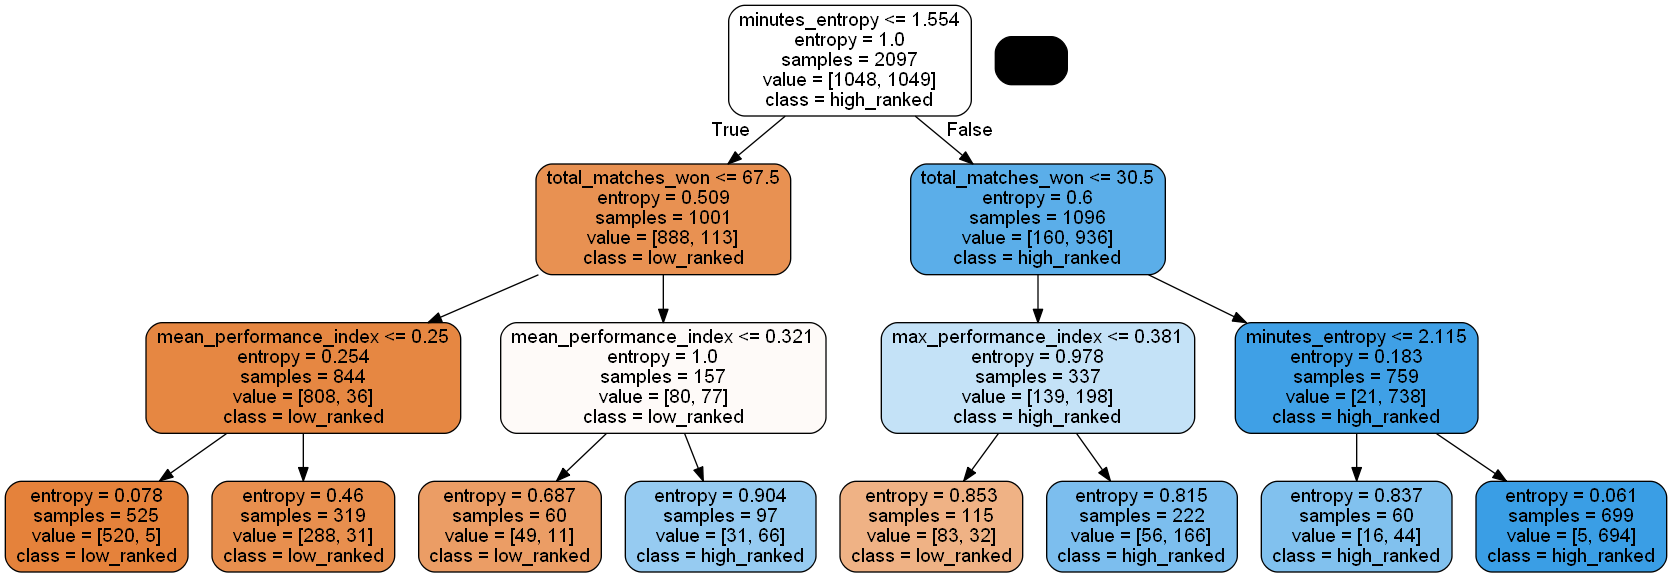

In [13]:
cdot_data = tree.export_graphviz(best_model["clf"], out_file=None,
                         feature_names=list(x_train.columns),
                         class_names=classes,
                         filled=True, rounded=True)
graph = pydotplus.graph_from_dot_data(cdot_data)
Image(graph.create_png())

#TODO: problema, cos'è il rettangolo nero?

#### Feature importance

In [42]:
# get the names of the most important features according to the model
# map the feature importances to the feature names
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': best_model["clf"].feature_importances_})
# sort according to the importance
feature_importances = feature_importances.sort_values('importance', ascending=False).reset_index(drop=True)
feature_importances

,feature,importance
0,minutes_entropy,0.693036
1,total_matches_won,0.231907
2,mean_performance_index,0.039194
3,max_performance_index,0.035863
4,total_tourneys_played,0.000000
5,total_matches_played,0.000000
6,matches_won_ratio,0.000000
7,min_performance_index,0.000000
8,performance_index_entropy,0.000000
9,age,0.000000


### Rule based (RIPPER)

In [43]:
# parameters = {"prune_size": [0.33, 0.5], "k": [1, 2]}
# clf = get_grid_search(lw.RIPPER(), parameters).fit(x_train, y_train, pos_class=1)
# y_pred = clf.predict(x_test)

# models.append(("Rule based", clf.best_estimator_))
# report(clf, X, Y, y_test, y_pred, clf.classes_)

In [44]:
# clf.best_estimator_.out_model()

### Random forest

In [45]:
parameters = {'max_depth': [2,3,4,5,6,7,8,9,10], 'n_estimators': [10, 20, 50, 100]}
best_model = fit_and_report("Random Forest", RandomForestClassifier(), parameters, X, Y, x_train, y_train, x_test, y_test, 'max_depth', normalization=False)

params,mean_train_score,mean_test_score,rank_test_score
"{'clf__max_depth': 9, 'clf__n_estimators': 100}",0.988317,0.902239,1
"{'clf__max_depth': 9, 'clf__n_estimators': 50}",0.987363,0.901288,2
"{'clf__max_depth': 8, 'clf__n_estimators': 50}",0.975799,0.900336,3
"{'clf__max_depth': 5, 'clf__n_estimators': 50}",0.935980,0.900335,4
"{'clf__max_depth': 6, 'clf__n_estimators': 100}",0.948498,0.899377,5
"{'clf__max_depth': 4, 'clf__n_estimators': 50}",0.922269,0.899376,6
"{'clf__max_depth': 10, 'clf__n_estimators': 100}",0.995351,0.898907,7
"{'clf__max_depth': 7, 'clf__n_estimators': 20}",0.962207,0.898906,8
"{'clf__max_depth': 5, 'clf__n_estimators': 100}",0.934430,0.898903,9
"{'clf__max_depth': 10, 'clf__n_estimators': 50}",0.993324,0.898429,10


Confusion matrix, without normalization


              precision    recall  f1-score   support

  low_ranked       0.89      0.92      0.91       450
 high_ranked       0.92      0.89      0.91       450

    accuracy                           0.91       900
   macro avg       0.91      0.91      0.91       900
weighted avg       0.91      0.91      0.91       900



### KNN

In [46]:
# Use SQRT heuristic on train set to find the optimal K
k_euristic = int(np.sqrt(len(x_train))) + 1
k_range = list(range(1, k_euristic, 2))

parameters = {'n_neighbors': k_range, 'weights':['uniform', 'distance'], 'algorithm': ['ball_tree', 'kd_tree', 'brute'], 'metric': ['euclidean', 'manhattan', 'minkowski']}
best_model = fit_and_report("KNN", KNeighborsClassifier(), parameters, X, Y, x_train, y_train, x_test, y_test, 'n_neighbors', normalization=True)

params,mean_train_score,mean_test_score,rank_test_score
"{'clf__algorithm': 'brute', 'clf__metric': 'euclidean', 'clf__n_neighbors': 17, 'clf__weights': 'uniform'}",0.909634,0.904152,1
"{'clf__algorithm': 'brute', 'clf__metric': 'minkowski', 'clf__n_neighbors': 17, 'clf__weights': 'uniform'}",0.909634,0.904152,1
"{'clf__algorithm': 'kd_tree', 'clf__metric': 'euclidean', 'clf__n_neighbors': 17, 'clf__weights': 'uniform'}",0.909634,0.904152,1
"{'clf__algorithm': 'ball_tree', 'clf__metric': 'euclidean', 'clf__n_neighbors': 17, 'clf__weights': 'uniform'}",0.909634,0.904152,1
"{'clf__algorithm': 'kd_tree', 'clf__metric': 'minkowski', 'clf__n_neighbors': 17, 'clf__weights': 'uniform'}",0.909634,0.904152,1
"{'clf__algorithm': 'ball_tree', 'clf__metric': 'minkowski', 'clf__n_neighbors': 17, 'clf__weights': 'uniform'}",0.909634,0.904152,1
"{'clf__algorithm': 'ball_tree', 'clf__metric': 'minkowski', 'clf__n_neighbors': 25, 'clf__weights': 'distance'}",1.000000,0.903681,7
"{'clf__algorithm': 'brute', 'clf__metric': 'euclidean', 'clf__n_neighbors': 25, 'clf__weights': 'distance'}",1.000000,0.903681,7
"{'clf__algorithm': 'ball_tree', 'clf__metric': 'euclidean', 'clf__n_neighbors': 25, 'clf__weights': 'distance'}",1.000000,0.903681,7
"{'clf__algorithm': 'kd_tree', 'clf__metric': 'minkowski', 'clf__n_neighbors': 25, 'clf__weights': 'distance'}",1.000000,0.903681,7


Confusion matrix, without normalization


              precision    recall  f1-score   support

  low_ranked       0.91      0.90      0.90       450
 high_ranked       0.90      0.91      0.90       450

    accuracy                           0.90       900
   macro avg       0.90      0.90      0.90       900
weighted avg       0.90      0.90      0.90       900



### Naive Bayes

In [ ]:
parameters = {}
best_model = fit_and_report("Naive Bayes", GaussianNB(), parameters, X, Y, x_train, y_train, x_test, y_test, '', normalization=True)

### Support Vector Machine

In [ ]:
parameters = {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
best_model = fit_and_report("SVM", SVC(probability=True), parameters, X, Y, x_train, y_train, x_test, y_test, 'C', normalization=True)

### Neural Networks

In [ ]:
parameters = {"solver": ['lbfgs', 'sgd', 'adam'], "alpha": [0.0001, 0.001, 0.01], "hidden_layer_sizes": [(10,), (20,)], "activation": ['identity', 'logistic', 'tanh', 'relu'], "learning_rate": ['constant', 'invscaling', 'adaptive']}
best_model = fit_and_report("Neural Network", MLPClassifier(), parameters, X, Y, x_train, y_train, x_test, y_test, 'alpha', normalization=True)

## Result analysis

### Comparison (ROC)

In [ ]:
fig = go.Figure()
fig.add_shape(type="line", x0=0, y0=0, x1=1, y1=1, line=dict(color="RoyalBlue",width=3, dash="dash"))

for i in range(len(models)):
    y_score = models[i][1].predict_proba(x_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    auc_score = roc_auc_score(y_test, y_score)
    models[i] += (auc_score,)
    
# Sort according to AUC score
models.sort(key=lambda x: x[2], reverse=True)  
for model in models:
    y_score = model[1].predict_proba(x_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    name = f"{model[0]} - AUC={model[2]:.3f}"
    fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'))

fig.update_layout(
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis=dict(constrain='domain'),
    width=700, height=500,
    autosize=True
)
fig.show()

### Visualization of the best model

In [ ]:
# search for the model with the best AUC score
best_model = max(models, key=lambda x: x[2])

# PCA
X_r = pd.DataFrame(PCA(n_components=2).fit_transform(x_train))
prediction = best_model[1].predict_proba(x_train)
fig = px.scatter(x=X_r[0], y=X_r[1], color=prediction[:, 1], color_continuous_scale='RdBu', symbol=y_train, symbol_map={'0': 'square-dot', '1': 'circle-dot'},  labels={'symbol': 'label', 'color': 'score of <br>first class'})
fig.update_traces(marker_size=12, marker_line_width=1.5)
fig.update_layout(title=f"PCA visualization for {best_model[0]}", legend_orientation='h')
fig.show()